In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Personal Color 분류 CLIP 4 - P-tuning v2

!pip install git+https://github.com/openai/CLIP.git
!pip install ftfy regex tqdm

import torch
import torch.nn as nn
import clip
from PIL import Image
import os
import glob
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-492_ke_a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-492_ke_a
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [5]:
class PromptEncoder(nn.Module):
    def __init__(self, prompt_length, hidden_size, hidden_dropout_prob=0.1):
        super().__init__()
        self.prompt_length = prompt_length

        # Prompt embeddings
        self.embedding = nn.Embedding(prompt_length, hidden_size)

        # MLP layers for prompt encoding
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(),
            nn.Linear(hidden_size * 4, hidden_size),
            nn.Dropout(hidden_dropout_prob)
        )

        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self):
        prompt_ids = torch.arange(self.prompt_length).long()
        if next(self.parameters()).is_cuda:
            prompt_ids = prompt_ids.cuda()

        # Ensure float32 type
        prompt_embeddings = self.embedding(prompt_ids).float()
        prompt_embeddings = self.mlp(prompt_embeddings)
        prompt_embeddings = self.layer_norm(prompt_embeddings)

        return prompt_embeddings

In [6]:
class PTuningV2CLIP(nn.Module):
    def __init__(self, classnames, clip_model, device, num_tokens=10):
        super().__init__()
        self.clip_model = clip_model.float()
        for param in self.clip_model.parameters():
            param.data = param.data.float()
        self.device = device
        self.num_tokens = num_tokens
        self.classnames = classnames
        self.n_cls = len(classnames)

        # CLIP의 context length 가져오기
        self.context_length = self.clip_model.context_length

        # Create prompt encoder for each transformer layer
        hidden_size = self.clip_model.token_embedding.weight.shape[1]
        self.prompt_encoders = nn.ModuleList([
            PromptEncoder(self.context_length, hidden_size)
            for _ in range(len(self.clip_model.transformer.resblocks))
        ])

        # Prepare class token embeddings
        with torch.no_grad():
            self.tokenized_prompts = []
            for name in classnames:
                tokens = clip.tokenize(f"a photo of a person with {name} color tone").to(device)
                self.tokenized_prompts.append(tokens)
            self.tokenized_prompts = torch.cat(self.tokenized_prompts)

    def forward_text(self, text_features):
        x = self.clip_model.token_embedding(text_features).float()

        # Add position embeddings
        x = x + self.clip_model.positional_embedding.float()

        # Apply text transformer
        x = x.permute(1, 0, 2)  # NLD -> LND

        # Instead of incorporating prompts, we'll use them to modify the hidden states
        for i, block in enumerate(self.clip_model.transformer.resblocks):
            # Get prompt embeddings
            prompt_emb = self.prompt_encoders[i]().float()

            # Reshape prompt embeddings to match sequence length
            prompt_emb = prompt_emb[:x.size(0)]  # Truncate or pad to match sequence length
            prompt_emb = prompt_emb.unsqueeze(1).expand(-1, x.size(1), -1)

            # Add prompt embeddings to hidden states
            x = x + prompt_emb
            x = block(x.float())

        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.clip_model.ln_final(x)

        # Take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]).to(self.device), text_features.argmax(dim=-1)]

        x = x @ self.clip_model.text_projection.float()
        return x

    def forward(self, image):
        # Ensure image is float32
        image = image.float()

        # Encode image
        image_features = self.clip_model.encode_image(image)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Process each prompt separately
        text_features = []
        for i in range(self.n_cls):
            class_text_features = self.forward_text(self.tokenized_prompts[i:i+1])
            text_features.append(class_text_features)
        text_features = torch.cat(text_features, dim=0)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Compute similarity
        logit_scale = self.clip_model.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

In [7]:
# PromptEncoder 클래스도 수정
class PromptEncoder(nn.Module):
    def __init__(self, prompt_length, hidden_size, hidden_dropout_prob=0.1):
        super().__init__()
        self.prompt_length = prompt_length

        # Prompt embeddings
        self.embedding = nn.Embedding(prompt_length, hidden_size)

        # MLP layers
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Dropout(hidden_dropout_prob)
        )

        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self):
        prompt_ids = torch.arange(self.prompt_length).long()
        if next(self.parameters()).is_cuda:
            prompt_ids = prompt_ids.cuda()

        prompt_embeddings = self.embedding(prompt_ids).float()
        prompt_embeddings = self.mlp(prompt_embeddings)
        prompt_embeddings = self.layer_norm(prompt_embeddings)

        return prompt_embeddings

In [8]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    class_names = ['spring', 'summer', 'fall', 'winter']

    # Generate detailed report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy, report, conf_matrix

100%|██████████| 30/30 [00:06<00:00,  5.00it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


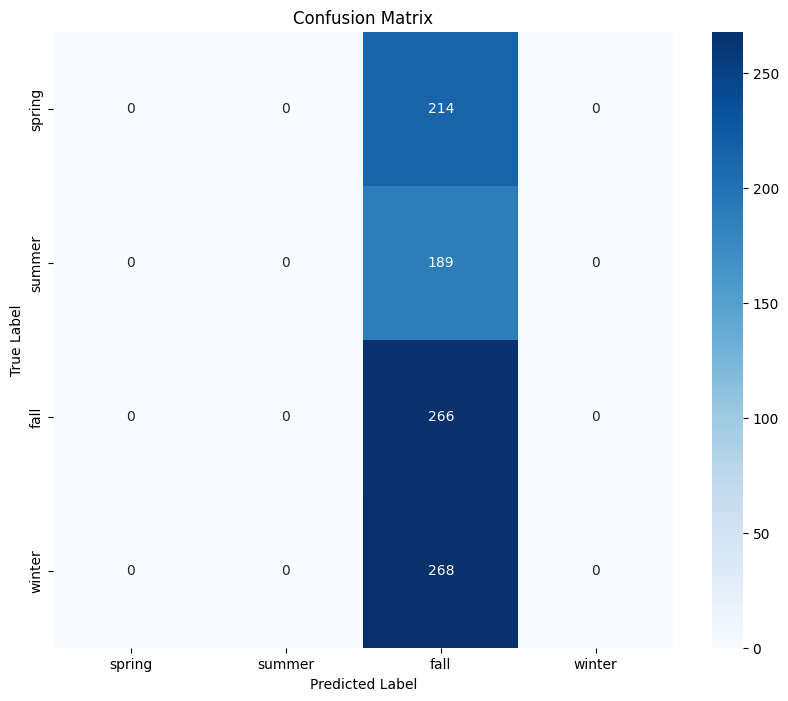


Epoch 1/5
Training Loss: 1.4899
Validation Accuracy: 0.2839

Classification Report:
              precision    recall  f1-score   support

      spring       0.00      0.00      0.00       214
      summer       0.00      0.00      0.00       189
        fall       0.28      1.00      0.44       266
      winter       0.00      0.00      0.00       268

    accuracy                           0.28       937
   macro avg       0.07      0.25      0.11       937
weighted avg       0.08      0.28      0.13       937



100%|██████████| 30/30 [00:06<00:00,  4.99it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


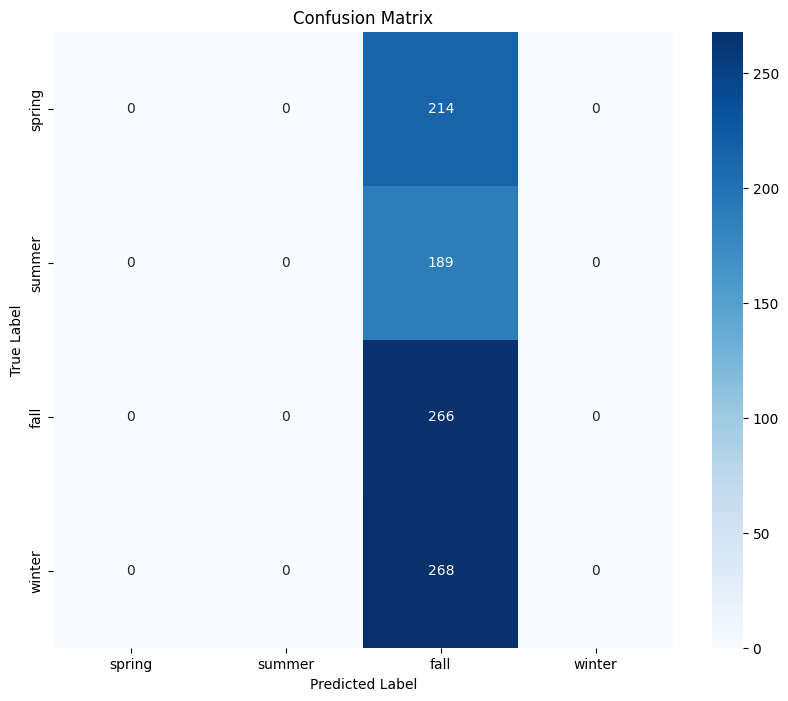


Epoch 2/5
Training Loss: 1.4068
Validation Accuracy: 0.2839

Classification Report:
              precision    recall  f1-score   support

      spring       0.00      0.00      0.00       214
      summer       0.00      0.00      0.00       189
        fall       0.28      1.00      0.44       266
      winter       0.00      0.00      0.00       268

    accuracy                           0.28       937
   macro avg       0.07      0.25      0.11       937
weighted avg       0.08      0.28      0.13       937



100%|██████████| 30/30 [00:05<00:00,  5.16it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


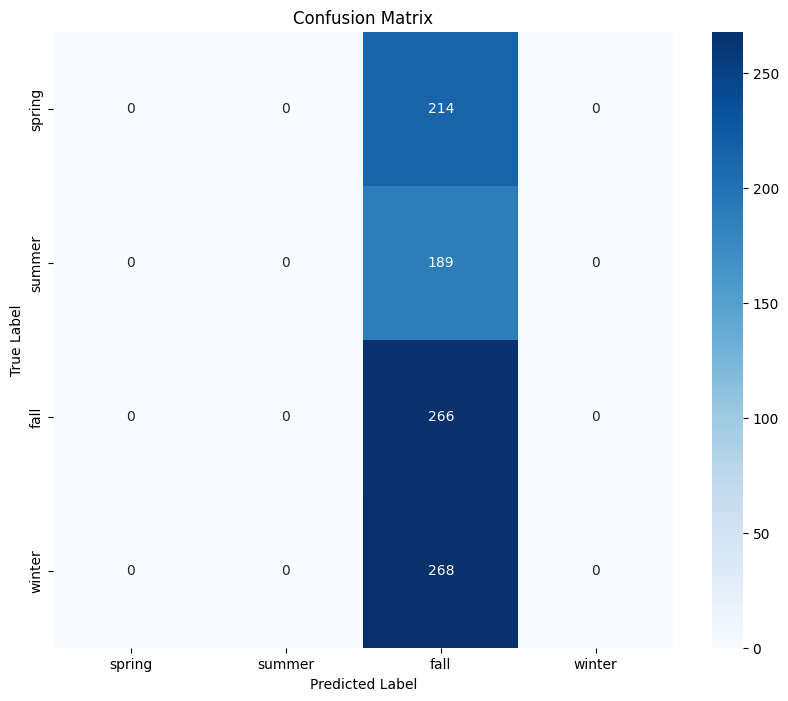


Epoch 3/5
Training Loss: 1.3995
Validation Accuracy: 0.2839

Classification Report:
              precision    recall  f1-score   support

      spring       0.00      0.00      0.00       214
      summer       0.00      0.00      0.00       189
        fall       0.28      1.00      0.44       266
      winter       0.00      0.00      0.00       268

    accuracy                           0.28       937
   macro avg       0.07      0.25      0.11       937
weighted avg       0.08      0.28      0.13       937



100%|██████████| 30/30 [00:05<00:00,  5.10it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


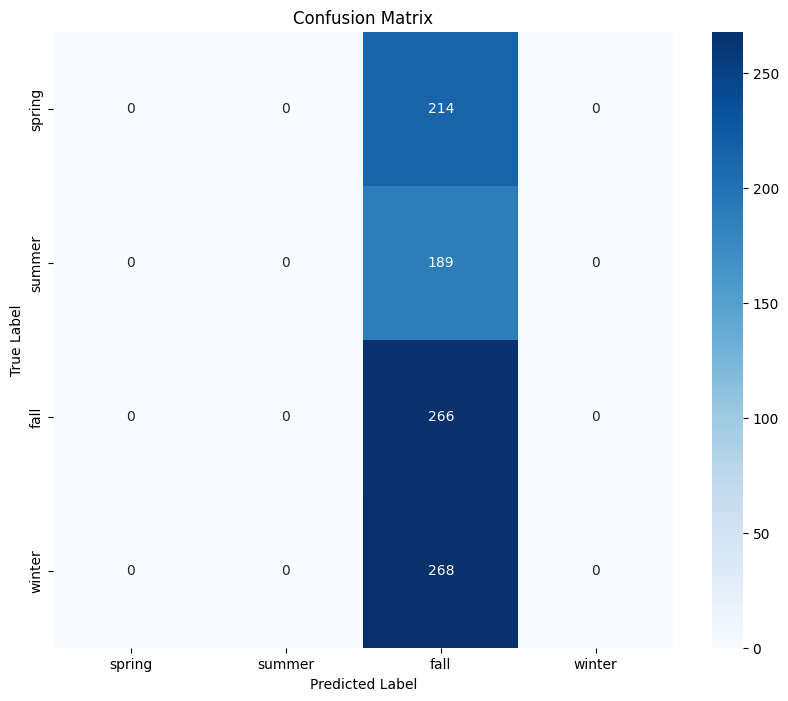


Epoch 4/5
Training Loss: 1.3983
Validation Accuracy: 0.2839

Classification Report:
              precision    recall  f1-score   support

      spring       0.00      0.00      0.00       214
      summer       0.00      0.00      0.00       189
        fall       0.28      1.00      0.44       266
      winter       0.00      0.00      0.00       268

    accuracy                           0.28       937
   macro avg       0.07      0.25      0.11       937
weighted avg       0.08      0.28      0.13       937



100%|██████████| 30/30 [00:06<00:00,  4.98it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


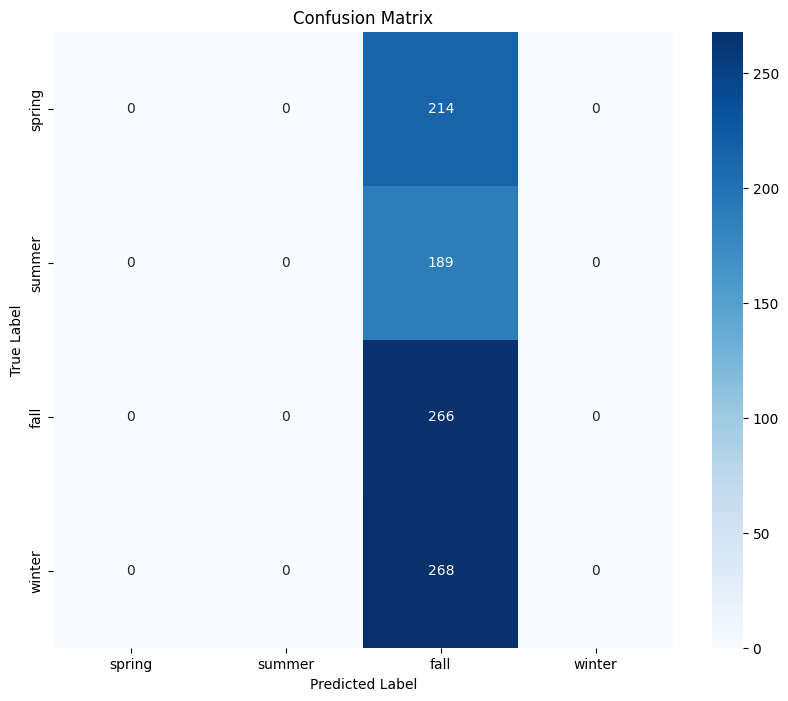


Epoch 5/5
Training Loss: 1.3936
Validation Accuracy: 0.2839

Classification Report:
              precision    recall  f1-score   support

      spring       0.00      0.00      0.00       214
      summer       0.00      0.00      0.00       189
        fall       0.28      1.00      0.44       266
      winter       0.00      0.00      0.00       268

    accuracy                           0.28       937
   macro avg       0.07      0.25      0.11       937
weighted avg       0.08      0.28      0.13       937



In [ ]:
def main():
    # Data preparation
    dataset_dir = '/content/drive/Othercomputers/내 노트북/personal-color-data/'
    dataset_types = ['train', 'test']
    class_folders = ['spring', 'summer', 'fall', 'winter']

    # Prepare image paths and labels
    image_paths = {'train': [], 'test': []}
    labels = {'train': [], 'test': []}

    for dataset_type in dataset_types:
        for idx, class_folder in enumerate(class_folders):
            class_dir = os.path.join(dataset_dir, dataset_type, class_folder)
            for img_path in glob.glob(os.path.join(class_dir, '*.*')):
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths[dataset_type].append(img_path)
                    labels[dataset_type].append(idx)

    # Set device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load CLIP model
    clip_model, _ = clip.load("ViT-B/32", device=device)

    # Initialize PTuningV2CLIP model
    model = PTuningV2CLIP(class_folders, clip_model, device).to(device)

    # Data loaders
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                           (0.26862954, 0.26130258, 0.27577711))
    ])

    class PersonalColorDataset(torch.utils.data.Dataset):
        def __init__(self, image_paths, labels, transform=None):
            self.image_paths = image_paths
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image = Image.open(self.image_paths[idx]).convert('RGB')
            if self.transform:
                image = self.transform(image)
            label = self.labels[idx]
            return image, label

    train_dataset = PersonalColorDataset(image_paths['train'], labels['train'], transform)
    val_dataset = PersonalColorDataset(image_paths['test'], labels['test'], transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss().to(device)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

    # Training loop
    num_epochs = 5
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            logits = model(images)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        scheduler.step()

        # Evaluate
        val_acc, val_report, val_conf_matrix = evaluate_model(model, val_loader, device)
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_loss/len(train_loader):.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
        print("\nClassification Report:")
        print(val_report) 

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_ptuningv2_model.pth')

if __name__ == "__main__":
    main()